In [1]:
import sys 
sys.path.insert(0,'/home/mohit.kumargupta/deep_boltzmann')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf

Using TensorFlow backend.
/home/mohit.kumargupta/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mohit.kumargupta/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mohit.kumargupta/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mohit.kumargupta/.local/lib/p

In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
rcParams.update({'font.size': 16})

In [4]:
%load_ext autoreload
%autoreload 2

In [6]:
from deep_boltzmann.models import ParticleDimer
from deep_boltzmann.networks.invertible import invnet, EnergyInvNet, create_RealNVPNet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.sampling.latent_sampling import BiasedModel
from deep_boltzmann.sampling.permutation import HungarianMapper
from deep_boltzmann.util import load_obj, save_obj
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [7]:
trajdict = np.load('output.npz')
import ast
#params = ast.literal_eval(str(trajdict['params']))
traj_closed_train = trajdict['traj_closed_train_hungarian']
traj_open_train = trajdict['traj_open_train_hungarian']
traj_closed_test = trajdict['traj_closed_test_hungarian']
traj_open_test = trajdict['traj_open_test_hungarian']
x = np.vstack([traj_closed_train, traj_open_train])
xval = np.vstack([traj_closed_test, traj_open_test])

In [8]:
model = ParticleDimer()

In [9]:
noise_intensity = 0.0
X0 = np.vstack([traj_closed_train, traj_open_train])
Nnoise = xval.shape[0]
X0noise = X0[np.random.choice(X0.shape[0], Nnoise)] + noise_intensity * np.random.randn(Nnoise, X0.shape[1])
X0noise = X0noise.astype(np.float32)

In [10]:
print(X0)
print(Nnoise)
print(X0noise)

[[-0.25        0.          0.25       ...  1.8         3.
   3.        ]
 [-0.25        0.          0.25       ...  1.8         3.
   3.        ]
 [-0.25        0.          0.25       ...  1.8         3.
   3.        ]
 ...
 [-1.0630857  -0.05359605  1.0554433  ...  1.7124369   3.0444221
   2.9039712 ]
 [-1.0630857  -0.05359605  1.0554433  ...  1.7124369   3.0444221
   2.9039712 ]
 [-1.0630857  -0.05359605  1.0554433  ...  1.7124369   3.0444221
   2.9039712 ]]
200002
[[-1.0223223   0.09796547  0.9895756  ...  1.864351    2.9479084
   3.0377867 ]
 [-0.39958864  0.13384998  0.5902655  ...  1.1954662   3.1360416
   2.7237735 ]
 [-0.96567434 -0.10744427  1.0639596  ...  1.6504312   3.0743759
   2.9262805 ]
 ...
 [-0.99676466  0.06643804  1.0608252  ...  1.9515302   2.8998432
   3.0253687 ]
 [-0.43608823 -0.06787441  0.46833077 ...  1.7974257   2.8506536
   2.900113  ]
 [-1.0186182  -0.1943088   1.0924151  ...  1.2962245   3.1156118
   2.7322419 ]]


In [11]:
def load(filename, energy_model, clear_session=True):
        """ Loads parameters into model. Careful: this clears the whole TF session!!
        """
        from deep_boltzmann.util import load_obj
        if clear_session:
                keras.backend.clear_session()
        D = load_obj(filename)
        prior = D['prior']
        layerdicts = D['layers']
        layers = [eval(d['type']).from_dict(d) for d in layerdicts]
        return EnergyInvNet(energy_model, layers, prior=prior)

In [12]:
bg = invnet(model.dim, 'RRRRRRRR', energy_model=model, nl_layers=4, nl_hidden=200, #100
            nl_activation='relu', nl_activation_scale='tanh', whiten=X0noise)
bg = bg.load('ParticleModel.pkl',model)

W<RRRRRRRR>
W 76 0 0
< 76 0 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
> 38 38 0


In [13]:
print(bg.transform_xz(np.array(traj_closed_train[100])))


[[ 1.9572871   0.40040457  0.52232695  1.781476    0.18984795  1.4211471
   1.4091525   0.3241893   0.47014692  0.27301317  0.05660808  1.5759212
   0.9411671   0.11529461 -0.36492828 -1.4029084   2.4879339  -0.19491223
  -2.4307282  -1.2326382   1.0743595  -0.3466315   2.1743069  -1.3172936
   0.08816743  0.80334145 -1.3519739  -1.1594777  -1.9806072  -1.3263477
   1.1516547  -0.03825116 -0.78479725  0.7388981   1.2666311  -0.8485985
   1.4399124   0.6204808   1.9062136   1.1174098  -0.5345829   1.6808631
  -1.4555068   0.79905385 -0.4415649  -0.0519985  -2.3669393   1.9275595
  -0.08194228 -0.8850203   1.0034795  -0.6269181  -3.0930343   0.27217174
  -1.8111589   1.2449567  -1.0462896  -1.0928485   0.0124515  -1.4201572
   0.01730096 -0.5653693   0.35124403  1.7833539   1.048368   -1.6191411
  -1.3836757  -1.632313   -0.6247406   1.7005564   1.1384866   0.5154846
  -2.2754784  -1.5632753   0.48130587  0.24134365]]


In [14]:
def latent_interpolation(bg, x1, x2, nstep=1000, through_origin=False):
    lambdas = np.array([np.linspace(0, 1, num=nstep)]).T
    x1 = np.array([x1])
    x2 = np.array([x2])
    z1 = bg.transform_xz(x1)
    z2 = bg.transform_xz(x2)
    if through_origin:
        zpath1 = z1 * (1-lambdas[::2])
        zpath2 = z2 * (lambdas[::2]) 
        zpath = np.vstack([zpath1, zpath2])
    else:
        zpath = z1 + lambdas*(z2-z1)
    xpath = bg.transform_zx(zpath)
    return xpath

In [15]:
Emin = 1e9
bestpath = None
for i in range(90):
    for j in range(90):
        path = latent_interpolation(bg, traj_closed_train[i*100], traj_open_train[j*100], nstep=9)
        E = model.energy(path).max()
        if E < Emin:
            Emin = E
            bestpath = path

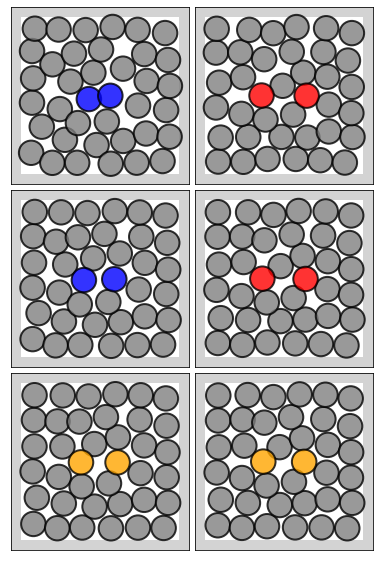

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6.5, 10))
model.draw_config(bestpath[0], axis=axes[0, 0], dimercolor='blue', alpha=0.8);
model.draw_config(bestpath[2], axis=axes[1, 0], dimercolor='blue', alpha=0.8);
model.draw_config(bestpath[3], axis=axes[2, 0], dimercolor='orange', alpha=0.8);
model.draw_config(bestpath[4], axis=axes[2, 1], dimercolor='orange', alpha=0.8);
model.draw_config(bestpath[5], axis=axes[1, 1], dimercolor='red', alpha=0.8);
model.draw_config(bestpath[7], axis=axes[0, 1], dimercolor='red', alpha=0.8);
plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.savefig('interpolate.pdf', bbox_inches='tight')

(0, 3)

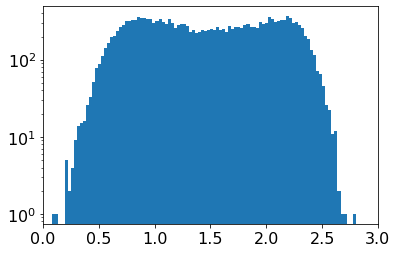

In [48]:
_, sample_x, _, energies_x, _ = bg.sample(nsample=20000)
sample_d = model.dimer_distance(sample_x)
plt.hist(sample_d[sample_d < 3], 100, log=True)
plt.xlim(0, 3)

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00272144, 0.0171691 , 0.06576486, 0.16794901, 0.32963471,
        0.53704463, 0.72318329, 0.86010586, 0.93840736, 0.97813841,
        0.99147548, 0.99598787, 0.99742864, 0.99757872, 0.99776882,
        0.99787888, 0.99787888, 0.99795892, 0.99799894, 0.99804897,
        0.99818904, 0.9984992 , 0.99855924, 0.99855924, 0.99865929,
        0.99870932, 0.99872933, 0.99901948, 0.99901948, 0.99910953,
        0.99910953, 0.99910953, 0.99910953, 0.99910953, 0.99913954,
        0.99913954, 0.99913954, 0.99913954, 0.99914955, 0.99914955,
        0.99921959, 0.99922959, 0.99922959, 0.99929963, 0.99929963,
        0.99932964, 0.99941969, 0.99941969, 0.99945971, 0.99945971,
        0.99945971, 0.99945971, 0.99946972, 0.99946972, 0.99946972,
        0.99946972, 0.99946972, 0.99953976, 0.99953976, 0.99955977,
        0.99955977, 0.9996198 , 0.99965982, 0.99

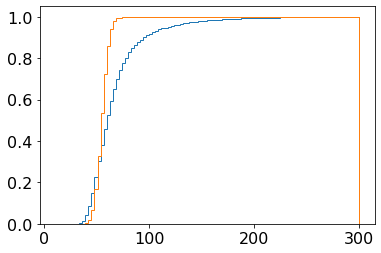

In [56]:
plt.hist(energies_x, bins =100, range=(10,300),cumulative= True,density = True,histtype ='step')
plt.hist(traj_closed_train_ener, bins=100, cumulative = True, histtype ='step',density =True,range=(10,300))


(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00272144, 0.0171691 , 0.06576486, 0.16794901, 0.32963471,
        0.53704463, 0.72318329, 0.86010586, 0.93840736, 0.97813841,
        0.99147548, 0.99598787, 0.99742864, 0.99757872, 0.99776882,
        0.99787888, 0.99787888, 0.99795892, 0.99799894, 0.99804897,
        0.99818904, 0.9984992 , 0.99855924, 0.99855924, 0.99865929,
        0.99870932, 0.99872933, 0.99901948, 0.99901948, 0.99910953,
        0.99910953, 0.99910953, 0.99910953, 0.99910953, 0.99913954,
        0.99913954, 0.99913954, 0.99913954, 0.99914955, 0.99914955,
        0.99921959, 0.99922959, 0.99922959, 0.99929963, 0.99929963,
        0.99932964, 0.99941969, 0.99941969, 0.99945971, 0.99945971,
        0.99945971, 0.99945971, 0.99946972, 0.99946972, 0.99946972,
        0.99946972, 0.99946972, 0.99953976, 0.99953976, 0.99955977,
        0.99955977, 0.9996198 , 0.99965982, 0.99

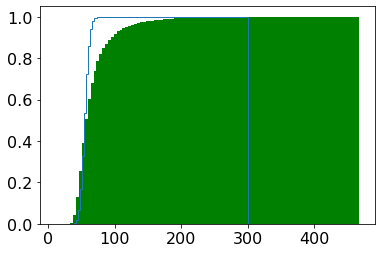

In [58]:
#plt.hist(energies_x[np.bitwise_and(energies_x<500, sample_d<1.2)], 100, color='yellow', cumulative = True, density=True);
plt.hist(energies_x[np.bitwise_and(energies_x<500, sample_d>1.8)], 100, color='green', density=True, cumulative= True);
plt.hist(traj_closed_train_ener, bins=100, cumulative = True, histtype ='step',density =True,range=(10,300))

#plt.hist(model.energy(traj_open_train), 100, color='blue', alpha=0.5, density=True);
#plt.hist(model.energy(traj_closed_train), 100, color='red', alpha=0.5, density=True);

In [27]:
traj_closed_train_ener = model.energy(traj_closed_train)
traj_open_train_ener = model.energy(traj_open_train)

In [28]:
_, sample_x, _, energies_x, _ = bg.sample(nsample=100000)

"\naxes[2].hist(traj_open_train_ener, 100, color='black', histtype='step', linewidth=2, density=True);\naxes[2].hist(traj_open_train_ener, 100, color='grey', alpha=0.5, density=True);\naxes[2].hist(energies_x_open, 100, color='red', histtype='step', linewidth=2, density=True);\naxes[2].hist(energies_x_open, 100, color='red', alpha=0.3, density=True);\naxes[2].set_yticks([])\naxes[2].set_xlim(20, 150)\naxes[2].set_ylim(0, 0.08)\naxes[2].set_xlabel('Energy / $kT_0$')\nplt.savefig(paper_dir + 'figs/particles/sampled_energies.pdf', transparent=True)\n"

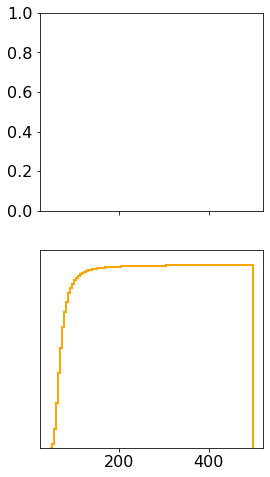

In [46]:
I_closed = np.where(model.dimer_distance(sample_x) < 1.3)[0]
energies_x_closed = energies_x[I_closed][energies_x[I_closed]<150]
I_ts = np.where(np.logical_and(model.dimer_distance(sample_x) > 1.3, model.dimer_distance(sample_x) < 1.7))[0]
energies_x_ts = energies_x[I_ts][energies_x[I_ts]<500]
I_open = np.where(model.dimer_distance(sample_x) > 1.7)[0]
energies_x_open = energies_x[I_open][energies_x[I_open]<150]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4, 8), sharex=True)
#plt.subplots_adjust(wspace=0.03, hspace=0.03)
'''
axes[0].hist(traj_closed_train_ener, 100, color='black', histtype='step', linewidth=2, density=True);
axes[0].hist(traj_closed_train_ener, 100, color='grey', alpha=0.5, density=True);
axes[0].hist(energies_x_closed, 100, color='blue', histtype='step', linewidth=2, density=True);
axes[0].hist(energies_x_closed, 100, color='blue', alpha=0.3, density=True);
axes[0].set_yticks([])
axes[0].set_ylim(0, 0.08)
axes[0].set_xlim(20, 150)
'''

axes[1].hist(energies_x_ts, 100, color='orange', histtype='step', linewidth=2, cumulative = True);
#axes[1].hist(energies_x_ts, 100, color='orange', alpha=0.3, density=True);
axes[1].set_yticks([])
axes[1].set_ylim(0, 20000)
#axes[1].set_xlim(20, 500)
'''
axes[2].hist(traj_open_train_ener, 100, color='black', histtype='step', linewidth=2, density=True);
axes[2].hist(traj_open_train_ener, 100, color='grey', alpha=0.5, density=True);
axes[2].hist(energies_x_open, 100, color='red', histtype='step', linewidth=2, density=True);
axes[2].hist(energies_x_open, 100, color='red', alpha=0.3, density=True);
axes[2].set_yticks([])
axes[2].set_xlim(20, 150)
axes[2].set_ylim(0, 0.08)
axes[2].set_xlabel('Energy / $kT_0$')
plt.savefig(paper_dir + 'figs/particles/sampled_energies.pdf', transparent=True)
'''